# KNN-regressor
Use k nearest neighbours to make prediction about process output

In [1]:
import pandas as pd
from statistics import mean
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline

import scipy.stats as stats
import math
from scipy.stats import norm

from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.optimize import differential_evolution
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

### Wczytaj i oczyść dane

In [2]:
def changeDateToSeconds(df):
    first = df["date"][0]
    df["date"] = df["date"].apply(lambda timestamp: (timestamp-first).seconds)
    return df

def readDataFromExcel(path, sheet):
    df = pd.read_excel(path, sheet_name=sheet, na_values=[" Bad Data","Bad Data"])
    df["date"] = pd.to_datetime(df["date"])
    df = changeDateToSeconds(df)
    return df

df2 = readDataFromExcel("./data/K-1_MI.xlsx", "d2")
df3 = readDataFromExcel("./data/K-1_MI.xlsx", "d3")
df5 = readDataFromExcel("./data/K-1_MI.xlsx", "d5")
df6 = readDataFromExcel("./data/K-1_MI.xlsx", "d6")

df6 = df6.iloc[::5, :] # dopasuj okresy próbkowania

dataFrames = [df2, df3, df5, df6]

for i, df in enumerate(dataFrames):
    if np.isnan(np.sum(df.values)):
        dataFrames[i] = dataFrames[i].interpolate()

In [3]:
all_dfs = dataFrames[0].append(dataFrames[1]).append(dataFrames[2]).append(dataFrames[3])
scaler = preprocessing.StandardScaler()
pure_data = all_dfs.drop(["date","LT2", "LT3", "LT4", "TMA","PWA", "PWF", "WP2", "WS1","WS2", "TTWT"], axis=1)
columns = pure_data.columns
scaler.fit(pure_data)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [4]:
np.isnan(np.sum(pure_data))

FP05    False
LT1     False
TMB     False
TMC     False
TMD     False
TME     False
TMF     False
PWB     False
PWC     False
PWD     False
PWE     False
PP      False
PW1     False
PW2     False
O2A     False
O2B     False
WP1     False
WDP     False
TP1     False
TP2     False
DP      False
TS1     False
TS2     False
FWF     False
ZS1     False
ZS2     False
LT01    False
PT05    False
PT01    False
TS01    False
TS03    False
TS02    False
FW01    False
TS05    False
TS04    False
FW02    False
TTWS    False
PTWS    False
TW02    False
TW01    False
FW03    False
TW04    False
TW03    False
FW04    False
PTWT    False
PPW     False
dtype: bool

In [5]:
dataFrames[2]

,date,FP05,LT1,LT2,LT3,LT4,TMA,TMB,TMC,TMD,...,PTWS,TW02,TW01,FW03,TW04,TW03,FW04,TTWT,PTWT,PPW
0,0,1081.4991,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6470,538.6156,324.4563,0.0000,541.0661,310.4243,9.8722,176.4025,10.5377,3.4916
1,10,1081.4991,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6360,538.6156,324.4563,0.0000,541.0661,310.4243,9.8722,176.4025,10.5377,3.4916
2,20,1079.9686,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6360,538.6156,324.4563,0.0000,541.0661,310.4243,9.8722,176.4025,10.5377,3.4916
3,30,1079.9686,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6195,538.6156,324.4563,0.0000,539.9727,310.4243,9.8722,176.4025,10.5268,3.4916
4,40,1079.9686,9.6676,-4.0825,11.714,9.9923,75.2533,55.7317,55.4180,58.1740,...,19.6195,538.6156,324.4563,0.0000,539.9727,310.4243,9.8722,176.4025,10.5268,3.4916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,9940,1072.3688,15.1995,2.3119,11.714,9.9923,72.1319,57.5103,54.3721,58.5927,...,19.4740,539.5197,321.0358,0.0000,540.4623,306.1097,10.4318,176.7647,10.4490,3.4771
995,9950,1072.3688,15.1995,2.3119,11.714,9.9923,72.1319,57.5103,54.3721,58.5927,...,19.4740,539.5197,321.0358,0.0000,540.4623,306.1097,10.4318,176.7647,10.4490,3.4771
996,9960,1072.3688,15.1995,2.3119,11.714,9.9923,72.1319,57.5103,54.3721,58.5927,...,19.4863,539.5197,321.0358,0.0000,540.4623,306.1097,10.4318,176.7647,10.4490,3.4771
997,9970,1072.3688,15.1995,2.3119,11.714,9.9923,72.1319,57.5103,54.3721,58.5927,...,19.4863,539.5197,322.8242,5.0621,540.4623,306.1097,10.4318,176.7647,10.4300,3.4771


In [29]:
scaledDataFrames = list()
for df in dataFrames:
    x = scaler.transform(df.drop(["date","LT2", "LT3", "LT4", "TMA","PWA", "PWF", "WP2", "WS1","WS2", "TTWT"], axis=1))
    scaledDataFrames.append(pd.DataFrame(x, columns=columns))

In [32]:
scaledDataFrames[0].head()

,FP05,LT1,TMB,TMC,TMD,TME,TMF,PWB,PWC,PWD,...,TTWS,PTWS,TW02,TW01,FW03,TW04,TW03,FW04,PTWT,PPW
0,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.270065,0.382458,-0.746469,0.934474,0.082002,-0.626244,0.862839,0.179704,0.688236
1,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.270065,0.382458,-0.746469,0.934474,0.082002,-0.626244,0.862839,0.179704,0.688236
2,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.243785,0.382458,-0.746469,0.934474,0.082002,-0.550439,0.862839,0.179704,0.633300
3,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.267982,0.382458,-0.628565,0.934474,0.082002,-0.550439,0.862839,0.179704,0.633300
4,0.494875,1.192373,0.839897,0.647031,0.695433,0.707325,-0.27716,0.50231,0.707426,0.573727,...,0.76711,0.267982,0.382458,-0.628565,0.934474,0.082002,-0.550439,0.862839,0.179704,0.633300


In [30]:
all_dfs = scaledDataFrames[0].append(scaledDataFrames[1]).append(scaledDataFrames[2]).append(scaledDataFrames[3])
scaled_inputs = all_dfs.drop(["LT01"], axis=1)

pca = PCA(0.99)
pca.fit(scaled_inputs)

principal_components = list()
for sdf in scaledDataFrames:
    pc = pca.transform(sdf.drop(["LT01"], axis=1))
    principal_components.append(pd.DataFrame(pc))

In [8]:
principal_components[1]

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-2.312739,1.615754,0.484870,-2.536004,-2.628759,1.550710,2.038750,0.631258,-0.089762,-1.215412,...,0.140797,-0.151278,-0.104359,0.344573,-0.368779,-0.152940,-0.043080,-0.694963,0.702938,-0.228198
1,-2.311389,1.608818,0.529418,-2.529161,-2.622192,1.563108,2.058269,0.615750,-0.069935,-1.208095,...,0.138714,-0.157363,-0.092801,0.260429,-0.389350,-0.359204,-0.029871,-0.702170,0.733283,-0.241077
2,-2.300151,1.531973,0.483257,-2.460059,-2.510345,1.676326,2.074189,0.623687,0.028768,-1.117673,...,0.138124,-0.131698,-0.130817,0.504473,-0.307666,0.300225,-0.089197,-0.589492,0.511416,-0.199433
3,-2.428553,1.523189,0.372075,-2.335862,-2.490385,1.738897,2.055065,0.659087,0.065177,-1.329286,...,-0.062368,-0.222879,-0.233909,0.371338,-0.257799,0.300568,-0.104316,-0.397529,0.406336,-0.213006
4,-2.346854,2.335986,0.699577,-2.560440,-2.622807,1.383117,2.216472,0.933723,-0.321118,-1.390914,...,0.301353,-0.447505,-0.371151,0.153062,-0.468458,-0.226334,0.664766,0.485952,-0.201861,-0.070381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,-2.716540,1.828202,-2.089027,2.358966,-2.375893,2.416021,-0.789296,-1.318293,-0.159809,0.166674,...,0.299828,-0.466643,0.192494,0.127466,0.381366,-0.058961,-0.487915,-0.223227,-0.153878,0.156268
995,-2.789207,1.756761,-1.984517,2.307838,-2.467238,2.396315,-0.758828,-1.501945,-0.195582,0.196209,...,0.421532,-0.325075,0.365970,0.201730,0.321970,-0.395371,-0.362788,-0.253312,-0.132797,0.194806
996,-2.751556,1.691950,-2.013758,2.270515,-2.377892,2.471481,-0.691258,-1.520885,-0.134580,0.346360,...,0.490669,-0.247954,0.391503,0.328702,0.379308,-0.301762,-0.333038,-0.257632,-0.132712,0.246810
997,-2.794712,1.714722,-1.892145,2.302016,-2.495500,2.397161,-0.741831,-1.611714,-0.161574,0.193655,...,0.487784,-0.276346,0.461310,0.153697,0.274312,-0.796498,-0.280459,-0.259483,-0.031533,0.200758


### KNNregressor

In [9]:
class KNNRegressor:
    def __init__(self, k=1):
        self.learning_set = list()
        self.k = k
        
    def add_data(self, data, output):
        self.learning_set.append((data, output))
        
    def find_distance(d1, d2):
        return np.linalg.norm(d1-d2)
    
    def predict(self, data):
        distances_iterator = map(lambda x: (KNNRegressor.find_distance(x[0], data), x[1]), self.learning_set)
        sorted_distances = sorted(distances_iterator, key=lambda x: x[0])
        
        nearest_neighbours = sorted_distances[:self.k]
        rate = list(map(lambda x: 1/(x+1), range(self.k)))
        outputs = list(map(lambda x: x[1], nearest_neighbours))
        
        model_output = sum(rate[g] * outputs[g] for g in range(len(rate))) / sum(rate)
#         model_output = mean(map(lambda x: x[1], nearest_neighbours))
        return model_output

In [10]:
df0 = principal_components[0].copy()
df0.insert(22, "LT01", scaledDataFrames[0]["LT01"].values)
[train0, test0] = train_test_split(df0, train_size=0.5, random_state=0)

df1 = principal_components[1].copy()
df1.insert(22, "LT01", scaledDataFrames[1]["LT01"].values)
[train1, test1] = train_test_split(df1, train_size=0.5, random_state=0)

df2 = principal_components[2].copy()
df2.insert(22, "LT01", scaledDataFrames[2]["LT01"].values)
[train2, test2] = train_test_split(df2, train_size=0.5, random_state=0)

df3 = principal_components[3].copy()
df3.insert(22, "LT01", scaledDataFrames[3]["LT01"].values)
[train3, test3] = train_test_split(df3, train_size=0.5, random_state=0)

In [11]:
train1

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,LT01
194,-2.590617,4.936118,1.425979,-1.260939,0.079089,-0.719698,0.601154,0.520427,-0.219102,0.337978,...,-0.563776,0.245138,0.088700,-0.183319,-0.323095,0.209437,0.010328,0.153680,0.187626,-0.806261
619,-4.056547,3.628449,-1.871680,2.011799,1.186098,-0.833340,0.095109,-0.044910,0.008777,-0.383844,...,0.868507,-0.109161,0.008618,0.399018,1.060437,-0.413869,-0.049418,-0.105253,-0.188814,-0.872174
401,-2.643305,3.721100,-0.391600,0.778883,-0.032579,-0.133180,0.623070,-1.437538,-1.068047,-0.039944,...,-0.581266,-0.680626,-0.031880,0.675045,-0.292775,1.221483,-0.556392,-0.002802,-0.247215,1.394005
529,-3.579999,4.505165,-0.914040,1.551835,1.289183,-2.121001,0.051779,0.155033,-0.046199,-0.060999,...,-0.001639,-0.304317,-0.294399,-0.154915,0.155090,0.593409,0.330137,0.227688,-0.280066,0.934349
655,-3.718289,4.712193,-1.155499,1.661726,0.926394,-1.616355,0.208319,0.109884,-0.433986,-0.196202,...,0.618585,-0.130976,-0.497801,0.118579,0.062594,0.193341,0.439843,-0.659018,-0.084224,0.093730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,-2.714105,0.196513,-2.156920,1.788701,-3.371096,2.125765,-0.379685,-0.607953,0.186925,0.159498,...,-0.111126,-0.196233,0.360863,-0.144136,0.202011,-0.219597,0.082182,0.016578,-0.190650,-1.099313
192,-2.708805,5.001125,1.285191,-1.244193,0.173571,-0.680320,0.655700,0.632174,-0.204810,0.466294,...,-0.607010,0.106519,-0.047073,-0.230149,-0.341659,0.177830,0.038211,0.236969,0.274881,-0.779669
629,-4.298357,3.179791,-1.950107,2.277142,0.969638,-0.574371,0.169091,-0.067335,0.300998,-0.450022,...,0.864694,0.062891,-0.349251,0.149163,0.112134,-0.166977,0.027389,-0.026610,-0.203357,-0.518013
559,-4.296378,2.765387,-2.186161,2.282660,0.990799,-0.973831,-0.146650,0.374933,0.526917,-0.698506,...,-0.019009,-0.038728,-0.557692,-0.065596,-0.133536,0.039860,-0.031344,0.526230,-0.482711,0.016512


In [12]:
knn = KNNRegressor(k=5)
for idx, row in enumerate(zip(train0.drop(["LT01"],axis=1).iterrows(), train0["LT01"])):
    inputs = row[0][1].values
    output = row[1]
    knn.add_data(inputs, output)
    
for idx, row in enumerate(zip(train1.drop(["LT01"],axis=1).iterrows(), train1["LT01"])):
    inputs = row[0][1].values
    output = row[1]
    knn.add_data(inputs, output)
    
for idx, row in enumerate(zip(train2.drop(["LT01"],axis=1).iterrows(), train2["LT01"])):
    inputs = row[0][1].values
    output = row[1]
    knn.add_data(inputs, output)
    
for idx, row in enumerate(zip(train3.drop(["LT01"],axis=1).iterrows(), train3["LT01"])):
    inputs = row[0][1].values
    output = row[1]
    knn.add_data(inputs, output)

### Data set 0

In [13]:
model_outputs0 = list()
real_outputs0 = list()
errors0 = list()
for i in range(len(test0)):
    model_output = knn.predict(test0.drop(["LT01"],axis=1).values[i])
    real_output = test0["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs0.append(model_output)
    real_outputs0.append(real_output)
    errors0.append(error)

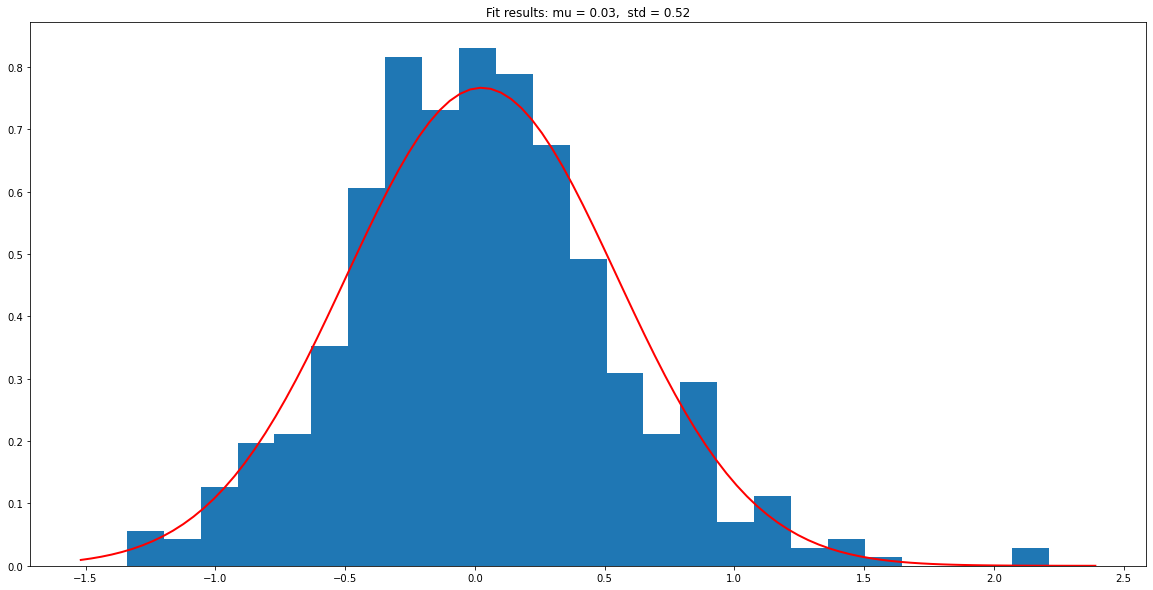

In [14]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors0, bins=25, density=True)

mu = np.array(errors0).mean()
sigma = np.array(errors0).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.799822447321672


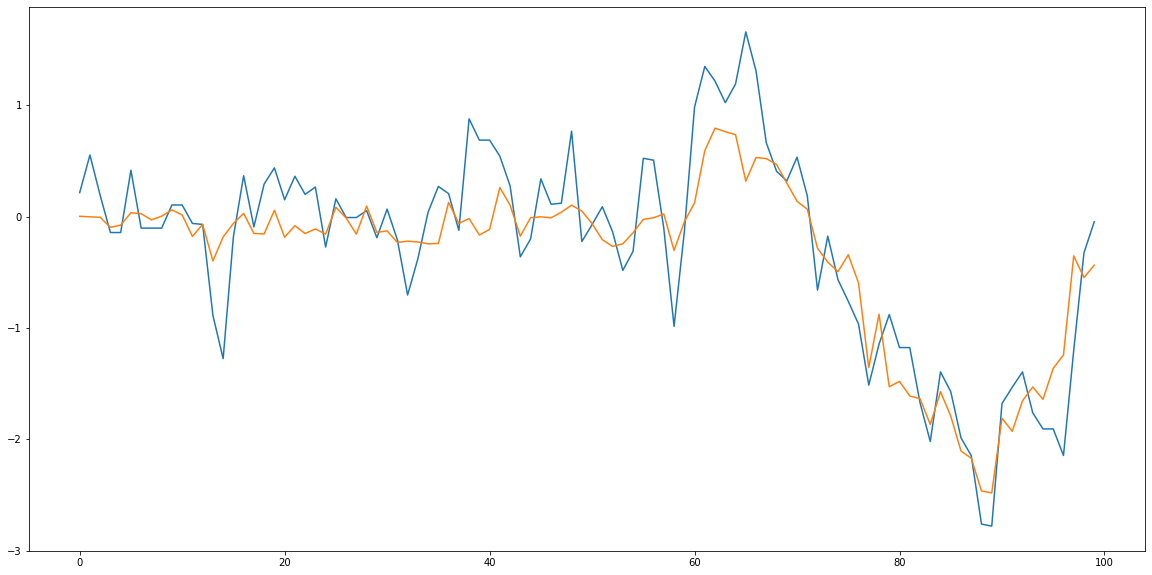

In [15]:
model_outputs0_all = list()
real_outputs0_all = list()
errors0_all = list()
for i in range(len(df0)):
    model_output = knn.predict(df0.drop(["LT01"],axis=1).values[i])
    real_output = df0["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs0_all.append(model_output)
    real_outputs0_all.append(real_output)
    errors0_all.append(error)

plt.plot(real_outputs0_all[:100])
plt.plot(model_outputs0_all[:100])
print(r2_score(real_outputs0_all, model_outputs0_all))

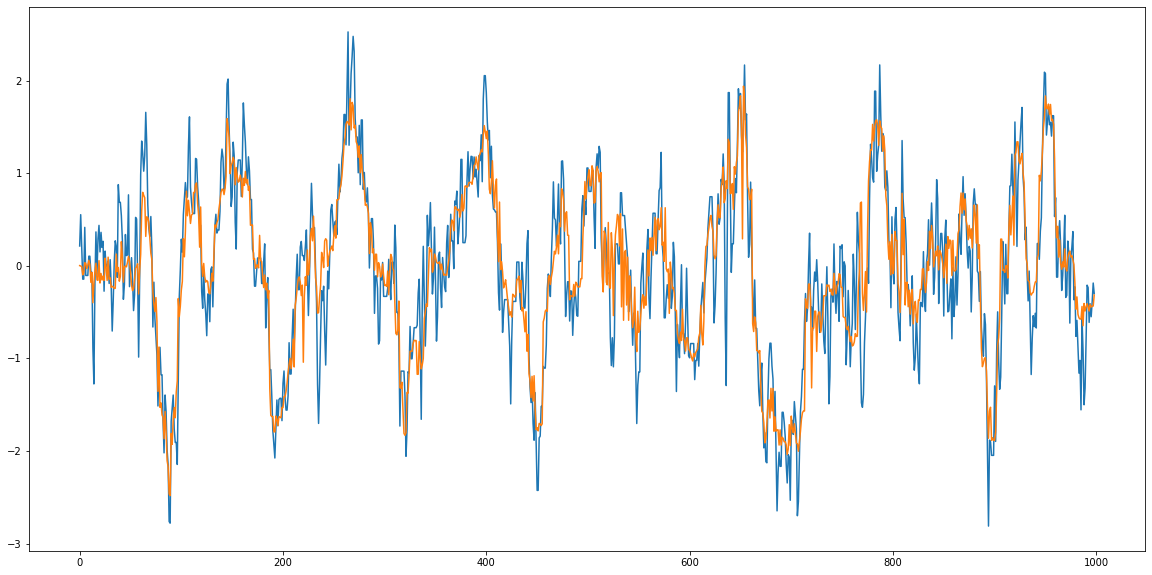

In [16]:
plt.plot(real_outputs0_all)
plt.plot(model_outputs0_all)

### Data set 1

In [17]:
model_outputs1 = list()
real_outputs1 = list()
errors1 = list()
for i in range(len(test1)):
    model_output = knn.predict(test1.drop(["LT01"],axis=1).values[i])
    real_output = test1["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs1.append(model_output)
    real_outputs1.append(real_output)
    errors1.append(error)

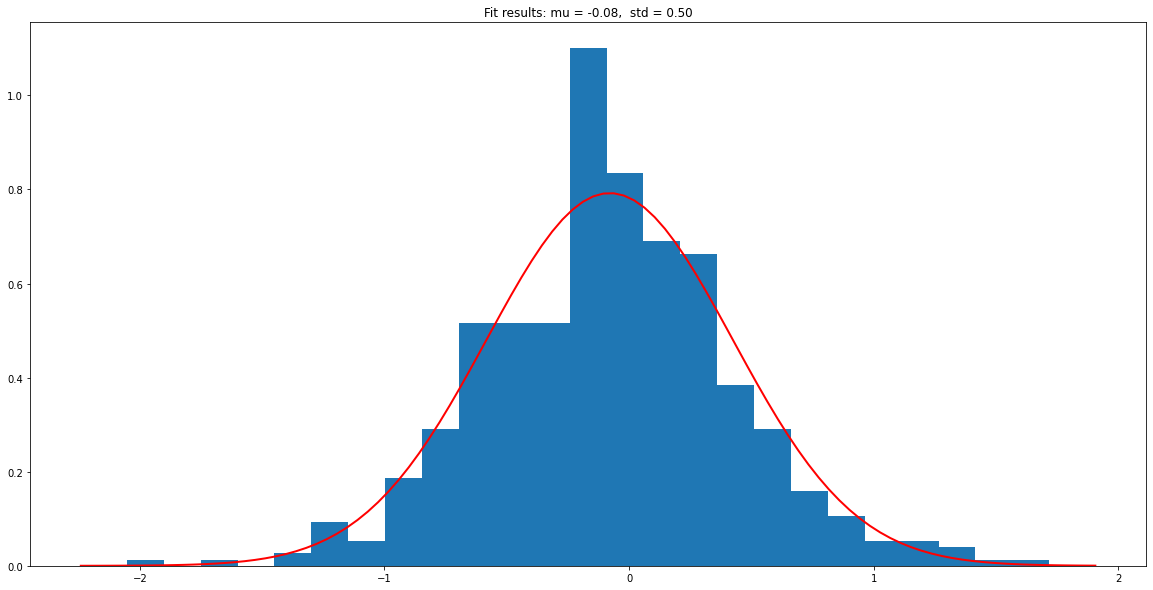

In [18]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors1, bins=25, density=True)

mu = np.array(errors1).mean()
sigma = np.array(errors1).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.7036153979818667


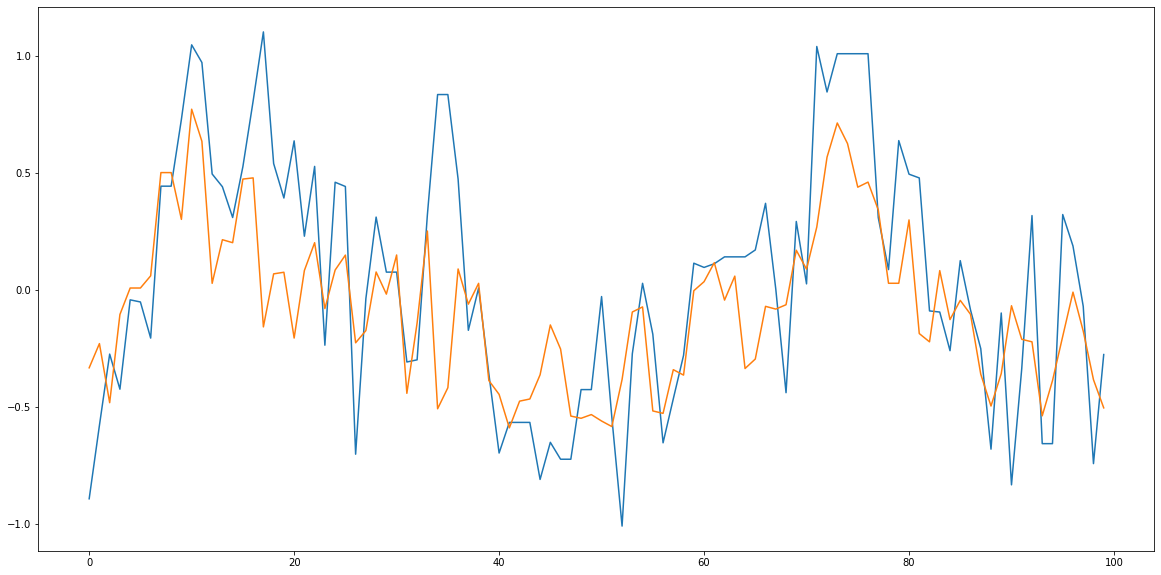

In [19]:
model_outputs1_all = list()
real_outputs1_all = list()
errors1_all = list()
for i in range(len(df1)):
    model_output = knn.predict(df1.drop(["LT01"],axis=1).values[i])
    real_output = df1["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs1_all.append(model_output)
    real_outputs1_all.append(real_output)
    errors1_all.append(error)

plt.plot(real_outputs1_all[:100])
plt.plot(model_outputs1_all[:100])
print(r2_score(real_outputs1_all, model_outputs1_all))

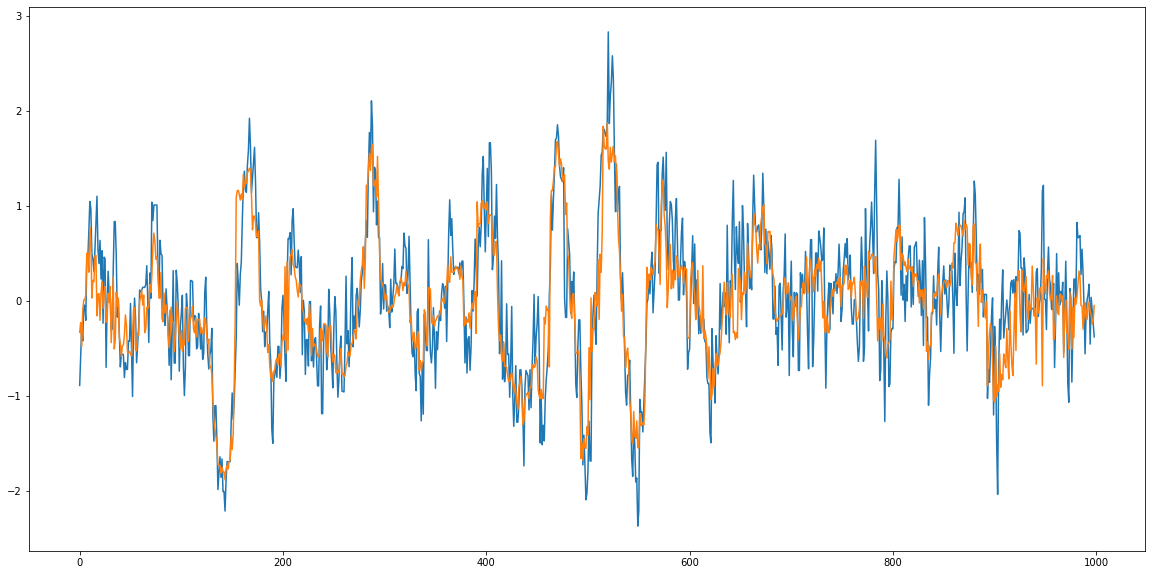

In [20]:
plt.plot(real_outputs1_all)
plt.plot(model_outputs1_all)

### Data set 2

In [21]:
model_outputs2 = list()
real_outputs2 = list()
errors2 = list()
for i in range(len(test2)):
    model_output = knn.predict(test2.drop(["LT01"],axis=1).values[i])
    real_output = test2["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs2.append(model_output)
    real_outputs2.append(real_output)
    errors2.append(error)

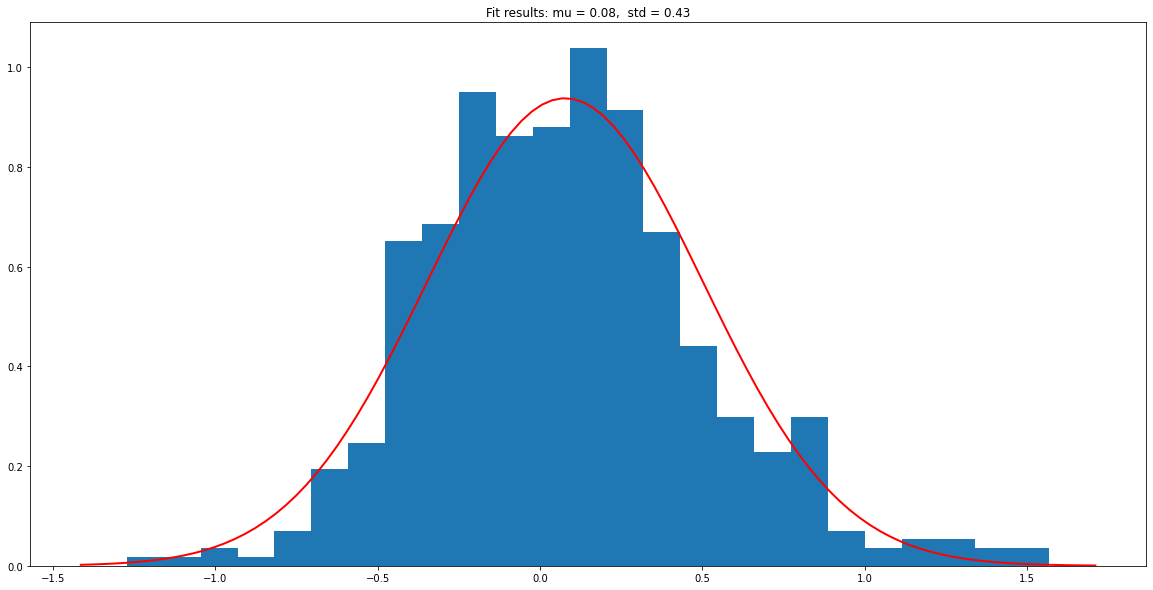

In [22]:
plt.rcParams['figure.figsize'] = [20, 10]
hist = plt.hist(errors2, bins=25, density=True)

mu = np.array(errors2).mean()
sigma = np.array(errors2).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.925097210657466


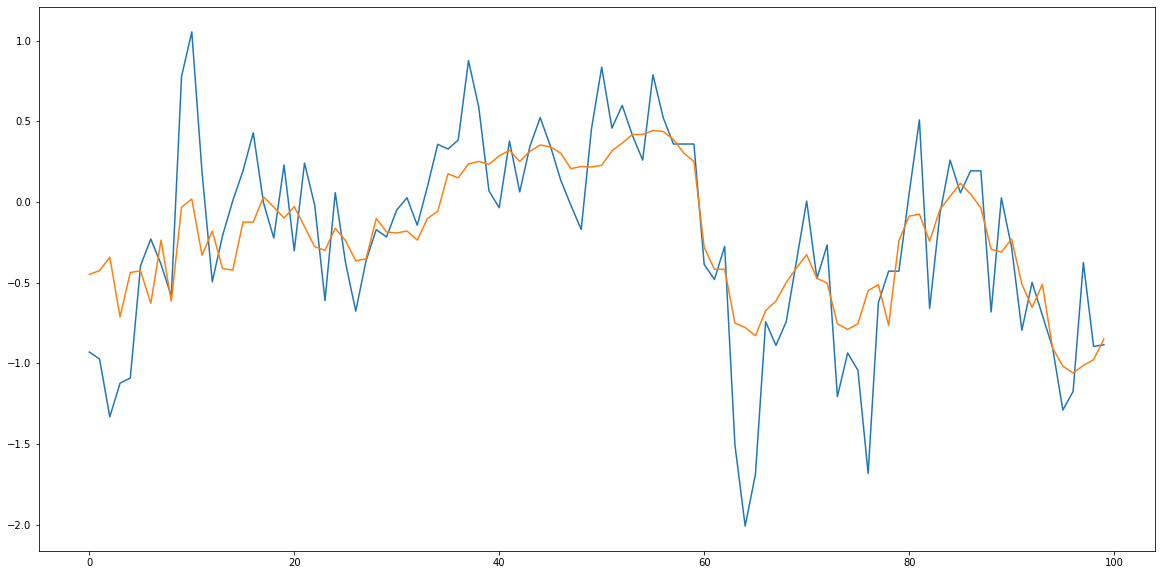

In [23]:
model_outputs2_all = list()
real_outputs2_all = list()
errors2_all = list()
for i in range(len(df2)):
    model_output = knn.predict(df2.drop(["LT01"],axis=1).values[i])
    real_output = df2["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs2_all.append(model_output)
    real_outputs2_all.append(real_output)
    errors2_all.append(error)

plt.plot(real_outputs2_all[:100])
plt.plot(model_outputs2_all[:100])
print(r2_score(real_outputs2_all, model_outputs2_all))

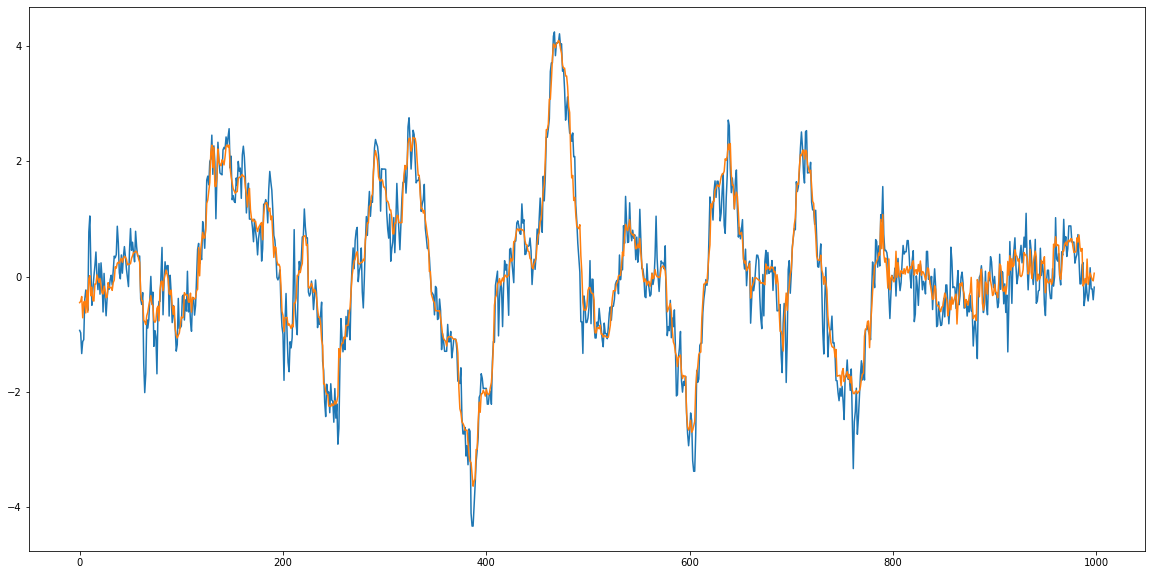

In [24]:
plt.plot(real_outputs2_all)
plt.plot(model_outputs2_all)

### Data set 3

In [25]:
model_outputs3 = list()
real_outputs3 = list()
errors3 = list()
for i in range(len(test3)):
    model_output = knn.predict(test3.drop(["LT01"],axis=1).values[i])
    real_output = test3["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs3.append(model_output)
    real_outputs3.append(real_output)
    errors3.append(error)

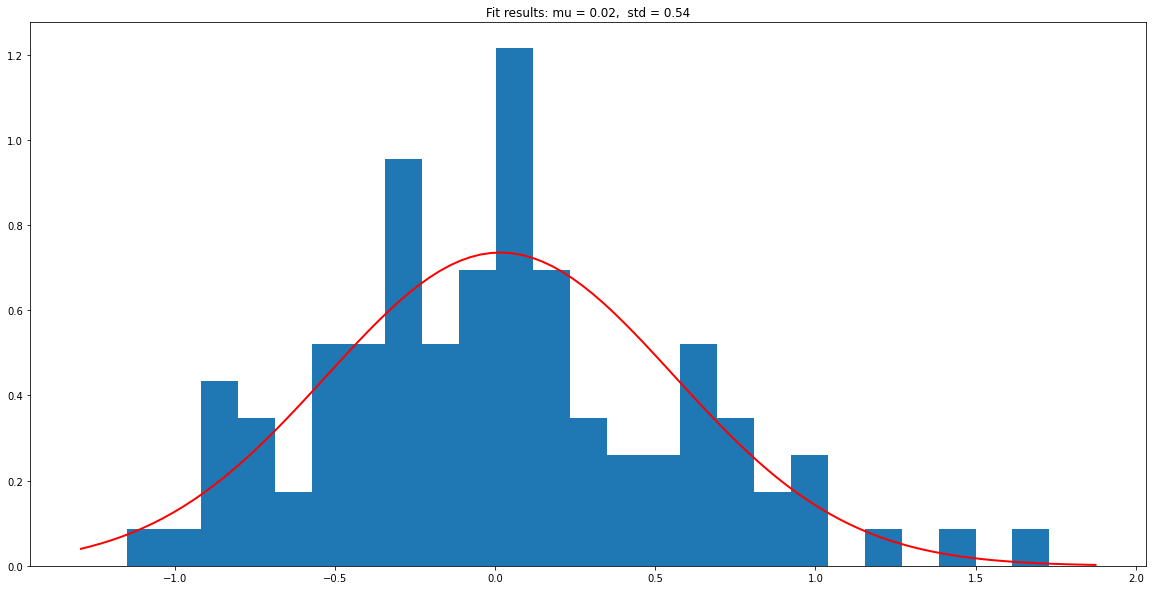

In [26]:
hist = plt.hist(errors3, bins=25, density=True)
mu = np.array(errors3).mean()
sigma = np.array(errors3).std()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, sigma)
plt.title(title)
plt.show()

0.41350304528694315


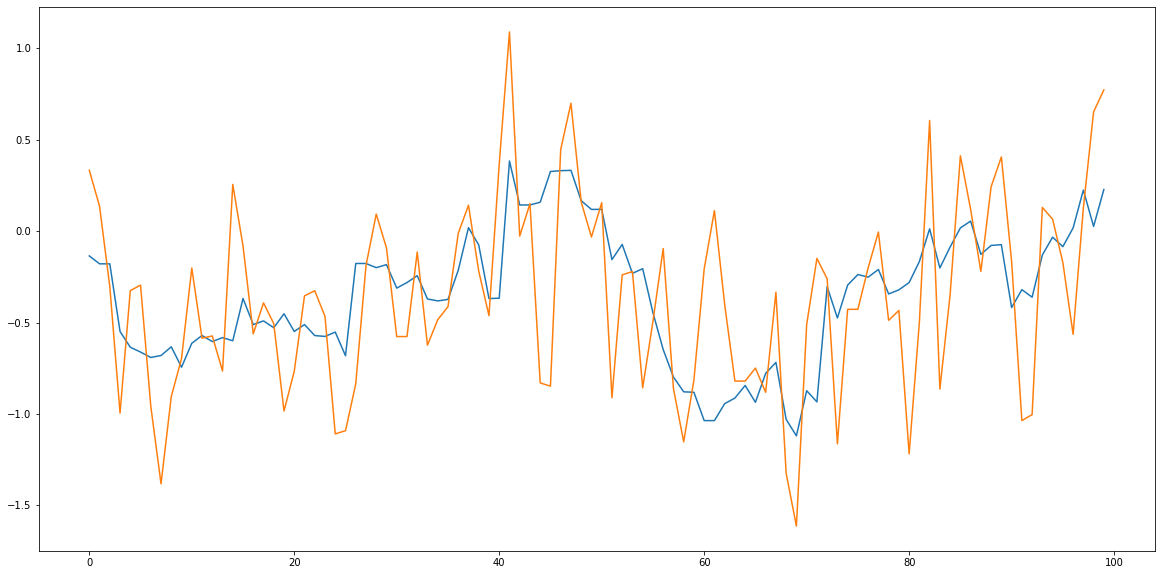

In [27]:
model_outputs3_all = list()
real_outputs3_all = list()
errors3_all = list()
for i in range(len(df3)):
    model_output = knn.predict(df3.drop(["LT01"],axis=1).values[i])
    real_output = df3["LT01"].values[i]
    error = (model_output - real_output)
    
    model_outputs3_all.append(model_output)
    real_outputs3_all.append(real_output)
    errors3_all.append(error)

plt.plot(model_outputs3_all[:100])
plt.plot(real_outputs3_all[:100])
print(r2_score(model_outputs3_all, real_outputs3_all))

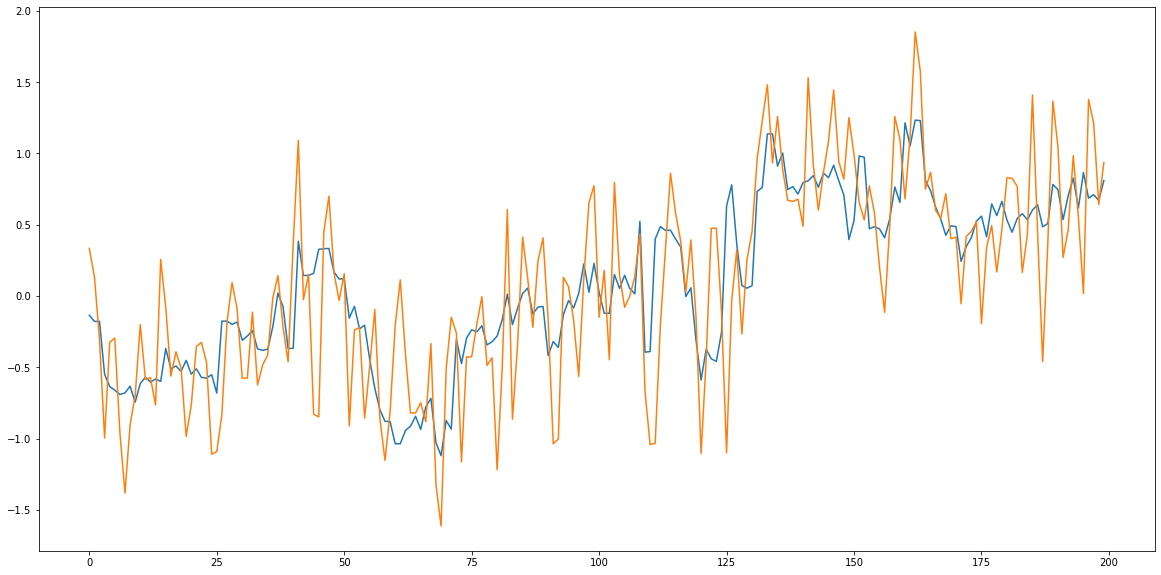

In [28]:
plt.plot(model_outputs3_all)
plt.plot(real_outputs3_all)